# Import

In [1]:
import os, sys
from functools import partial
import numpy as np
from scipy.constants import c
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm

In [2]:
def get_value_cst_output(cell, parameter):
    lparameter = len(parameter) + 1
    idx_start = cell.find(parameter) + lparameter
    idx_end = idx_start + cell[idx_start:].find('}')
    return float(cell[idx_start:idx_end])

## Example with a simulated pillbox impedance and wake function
The simulation was run with different wake length to assess its impact on the impedance. It can be modified in this notebook.

In [30]:
with open(os.path.join('impedance.txt')) as fil:
    contents = fil.readlines()
    fil.close()

idx_scan = [i for i,c in enumerate(contents) if 'Parameters' in c]
n_scan = len(idx_scan)
wake_length_scan = np.array([get_value_cst_output(contents[i], 'wake_length') for i in idx_scan])/100

impedances_wake_length = {}
for iidx, idx in enumerate(idx_scan):
    imp_txt = contents[idx + 3:idx + idx_scan[1]-idx_scan[0]]
    imp_txt = [i.replace('\n', '') for i in imp_txt]
    imp_txt = [i.split('\t') for i in imp_txt]
    imp_txt = [float(j) for i in imp_txt for j in i]
    imp = np.array(imp_txt).reshape(-1, 3)
    imp[:, 1:] /= 1e-2
    impedances_wake_length[wake_length_scan[iidx]] = imp

with open(os.path.join('wake.txt')) as fil:
    contents = fil.readlines()
    fil.close()

idx_scan = [i for i,c in enumerate(contents) if 'Parameters' in c] + [-1]
n_scan = len(idx_scan)
wake_length_scan = np.array([get_value_cst_output(contents[i], 'wake_length') for i in idx_scan[:-1]])/100

wakes_wake_length = {}
for iidx, idx in enumerate(idx_scan[:-1]):
    wake_txt = contents[idx + 3:idx + idx_scan[iidx+1]-idx_scan[iidx]]
    wake_txt = [i.replace('\n', '') for i in wake_txt]
    wake_txt = [i.split('\t') for i in wake_txt]
    wake_txt = [float(j) for i in wake_txt for j in i]
    wakes_wake_length[wake_length_scan[iidx]] = np.array(wake_txt).reshape(-1, 2)

ValueError: could not convert string to float: ' = {charge_param=1e-09; time_step_stability_factor=0.5; cond=1000; wakelength=10000; cpw=10'

In [ ]:
first_key = list(impedances_wake_length.keys())[0]
print(f"Data for the first key ({first_key}):")
print(impedances_wake_length[first_key][:,0])

Data for the first key (10.0):
[0.00000000e+00 1.70652404e-05 3.41304809e-05 ... 1.70648991e+00
 1.70650698e+00 1.70652404e+00]


In [2]:
# Importing impedance data
data_impedance = np.loadtxt('impedance.txt', comments='#', delimiter='\t')
print(data_impedance)

# Importing wake data
data_wake = np.loadtxt('wake.txt', comments='#', delimiter='\t')
print(data_wake)

[[ 0.00000000e+00 -1.09872127e+00  1.23587939e-10]
 [ 1.02391446e-03  6.09389605e-01  1.18400092e+00]
 [ 2.04782892e-03  5.13237337e-01 -4.89157269e-01]
 ...
 [ 1.02186663e+00  6.02759684e+00 -4.87659067e+00]
 [ 1.02289055e+00  8.61613367e+00 -1.15127814e+01]
 [ 1.02391446e+00  7.20793227e-01 -8.36558087e+00]]
[[-8.54892103e+01 -1.35731256e-14]
 [-8.54045012e+01 -1.37987966e-14]
 [-8.53197920e+01 -1.38760949e-14]
 ...
 [ 9.99981323e+03 -1.16007318e-03]
 [ 9.99989794e+03 -1.19438596e-03]
 [ 9.99998265e+03 -1.22861344e-03]]


In [3]:
#Studied component, can be set to dipx, dipy, quadx or quady
component = "long"

#Number of resonators
Nres = 2 # can be changed to see what happens

wake_length = 100 # simulated wake length in [m], can be 10, 500, 1000, 2000, 4000
frequency_data = data_impedance[:,0]*1e9 #frequencies in Hz
impedance_data = np.array(data_impedance[:,1] + \
                          1j*data_impedance[:,2])

# wake_data = wakes_wake_length[wake_length]
#wake_data = data_wake[data_wake[:,0] >= 0]
time_data = np.array(data_wake[:,0])*1e-2/c
wake_data = np.array(data_wake[:,1])/100

#supply the wake length to the resonator formula to use the 
#partially decayed wake variant 
n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, 
                                                     wake_length=wake_length
                                                    )

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """
bounds = [(1e3, 10e3), (1, 5e3), (0.1e9, 1e9)]
parameterBounds = Nres * bounds

## Let us run the genetic algorithm with a partially decayed wake impedance using the scipy solver. 
Due to the function complexity, its evaluation is more computationaly intensive thus slow down the algorithm. For this reason, the partially decayed wake formalism should **not** be used in the general case where the usual formalism is preferred.

The parameter bounds are quite loose hence it leads to a slow convergence to the optimal solution. 

In [4]:
%%time
GA_model_scipy = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                 )

GA_model_scipy.run_geneticAlgorithm(maxiter=3000, 
                                    popsize=25, 
                                    tol=1e-2, 
                                    mutation=(0.3, 0.8), 
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy.warning)

Progress: [#######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.30e+03        |      174.35      |    8.166e+08     
    2     |        8.54e+03        |      199.49      |    5.480e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 1.21 s, sys: 203 ms, total: 1.42 s
Wall time: 1.58 s


## After running the genetic algorithm, I can refine the solution by running a minimization algorithm. 
I let each parameter change by up to 50% with the margin argument.

In [5]:
%%time
GA_model_scipy.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.33e+03        |      175.11      |    8.166e+08     
    2     |        8.54e+03        |      199.67      |    5.480e+08     
----------------------------------------------------------------------
CPU times: user 55.8 ms, sys: 21 µs, total: 55.9 ms
Wall time: 55.2 ms


In [11]:
GA_model_scipy.frequency_data

AttributeError: 'GeneticAlgorithm' object has no attribute 'results'

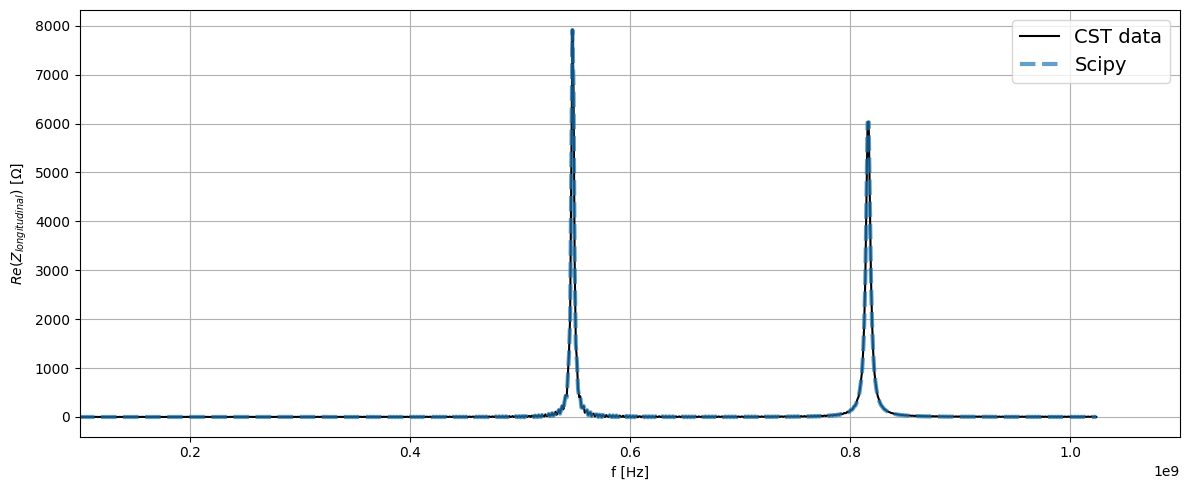

In [6]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

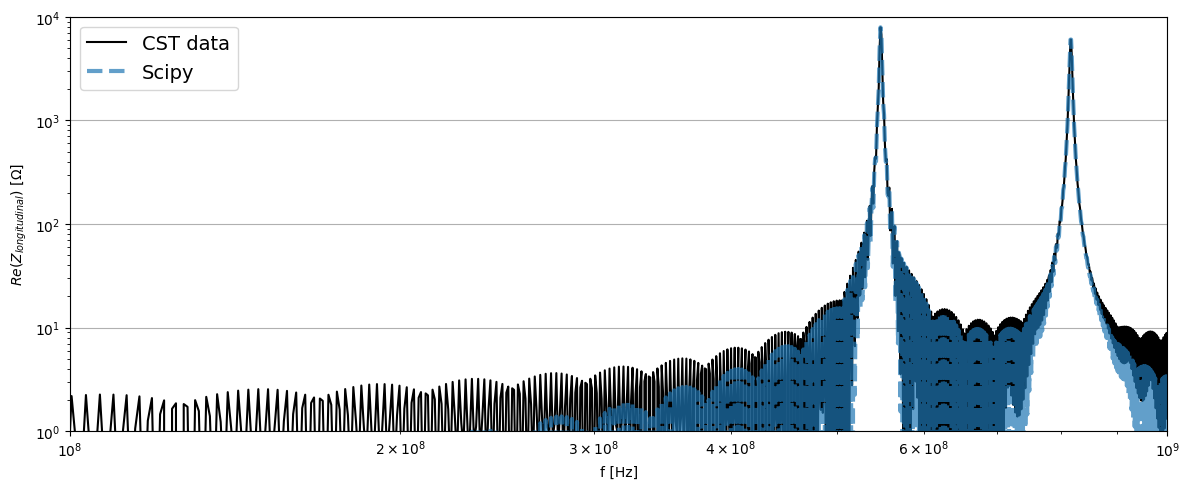

In [74]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.grid()

ax0.set_xlim(0.1e9, 1e9)
ax0.set_ylim(1, 10e3)

fig.tight_layout()

# Crosscheck with the wake
Here I load the CST wake and compare with the wake function reconstruction obtained from the fitted resonators parameters. Beware, a $-2 \pi$ normalization is required to match CST wake function convention.

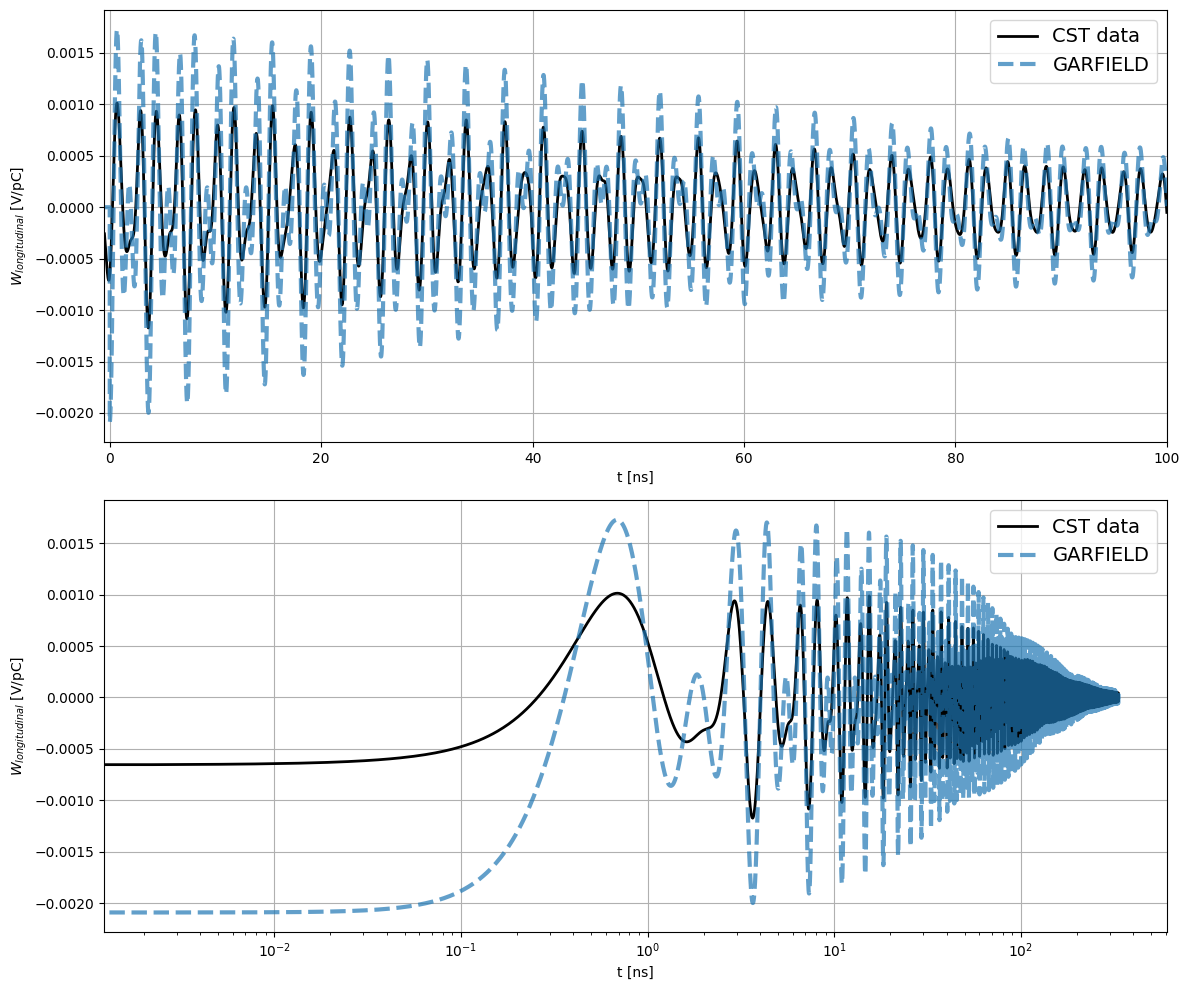

In [75]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(GA_model_scipy.time_data*1e9, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax0.plot(GA_model_scipy.time_data*1e9, -2*np.pi*n_Resonator_longitudinal_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='GARFIELD', alpha=0.7)

ax1.plot(GA_model_scipy.time_data*1e9, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax1.plot(GA_model_scipy.time_data*1e9, -2*np.pi*n_Resonator_longitudinal_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-15,
         lw = 3, linestyle='--', label='GARFIELD', alpha=0.7)

ax1.set_xscale('log')

ax0.set_xlabel('t [ns]')
ax1.set_xlabel('t [ns]')

ax0.set_ylabel('$W_{longitudinal}$ [V/pC]')
ax1.set_ylabel('$W_{longitudinal}$ [V/pC]')

ax0.set_xlim(-0.5, 100)

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

ax0.grid()
ax1.grid()

fig.tight_layout()